# 01 – EDA: Bike Sharing Demand

Bu notebook, BikeSharing-ML-Pipeline projesi için keşifsel veri analizi (EDA) adımlarını içerir.

Amaç:

- Veri setinin genel yapısını anlamak
- Hedef değişkenin (count) dağılımını incelemek
- Zaman, hava durumu ve takvim değişkenleri ile talep ilişkisini görmek
- Sonraki aşamalarda kullanılacak feature engineering fikirlerini çıkarmak


In [7]:
import os
from pathlib import Path

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats

#her çalıştırdığımda sonuçların değişmemesi için seed sabitlemesi 
SEED = 42
np.random.seed(SEED)

import warnings
warnings.filterwarnings("ignore")

plt.style.use("ggplot")
pd.set_option("display.max_columns", 50)

#Sayıların bilimsel gösterim (e+04) yerine düzgün okunması için
pd.set_option('display.float_format', lambda x: '%.3f' % x)

DATA_PATH = Path("../data/raw")
FIGURES = Path("../figures")
FIGURES.mkdir(parents=True, exist_ok=True)

train_path = DATA_PATH / "train.csv"
test_path = DATA_PATH / "test.csv"

print("Kütüphaneler yüklendi")


Kütüphaneler yüklendi


In [8]:
train = pd.read_csv(train_path, parse_dates=['datetime'])
test = pd.read_csv(test_path, parse_dates=['datetime'])

print(f"Train Shape: {train.shape}")
print(f"Test Shape:  {test.shape}")

print("-" * 30)
train.info()
print("-" * 30)

train.head()



Train Shape: (10886, 12)
Test Shape:  (6493, 9)
------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   datetime    10886 non-null  datetime64[ns]
 1   season      10886 non-null  int64         
 2   holiday     10886 non-null  int64         
 3   workingday  10886 non-null  int64         
 4   weather     10886 non-null  int64         
 5   temp        10886 non-null  float64       
 6   atemp       10886 non-null  float64       
 7   humidity    10886 non-null  int64         
 8   windspeed   10886 non-null  float64       
 9   casual      10886 non-null  int64         
 10  registered  10886 non-null  int64         
 11  count       10886 non-null  int64         
dtypes: datetime64[ns](1), float64(3), int64(8)
memory usage: 1020.7 KB
------------------------------


,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.840,14.395,81,0.000,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.020,13.635,80,0.000,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.020,13.635,80,0.000,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.840,14.395,75,0.000,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.840,14.395,75,0.000,0,1,1


- **Veri Yapısı:** Test setinde sütun sayısı daha az. Bu beklenen bir durum çünkü `count` (hedef) değişkeni ve onun alt kırılımları (`casual`, `registered`) sadece train setinde var.
- **Datetime:** Saatler düzenli şekilde (1 saat aralıkla) artıyor, buradan zaman bazlı featurelar türetilecek.
- **Season:** Kaggle açıklamasına göre kategorik (1=ilkbahar, 2=yaz, 3=sonbahar, 4=kış). Modelin sayısal büyüklük sanmaması için dikkat edilmeli.
- **Holiday & Workingday:** Tatil ve iş günü ayrımı, kullanıcı davranışını (işe gidiş vs. gezi) anlamak için kritik FE adayları.
- **Weather:** Kaggle açıklamasına göre kategorik (1=Açık... 4=Ağır fırtına). 4 numaralı hava durumu çok nadir olabilir, kontrol edilecek.
- **Temp & Atemp:** Sıcaklık ve hissedilen sıcaklık muhtemelen birbirine çok yakın (korelasyon yüksek). İkisini aynı anda kullanmak modelde "multicollinearity" sorunu yaratabilir, biri seçilebilir.
- **Windspeed:** Rüzgar hızı kolonunda çok fazla 0 var. Rüzgarın 0 olması fiziksel olarak zor, muhtemelen ölçülemeyen değerler 0 ile doldurulmuş (imputation hatası olabilir). Düzeltilmesi gerekebilir.
- **Target Analizi (Count = Casual + Registered):**
    - `casual`: Kayıtlı olmayan, günlük kullanıcılar.
    - `registered`: Kayıtlı, muhtemelen abone kullanıcılar.
    - `count`: Toplam kiralama.
    - *Not:* `casual` ve `registered` değişkenleri test setinde olmadığı için modelde **input (feature)** olarak kullanılamaz (Data Leakage olur!). Ancak EDA sürecinde bu iki kitleyi ayrı ayrı incelemek iş modelini anlamak için şart.


In [6]:
train.info()
train.isna().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   datetime    10886 non-null  object 
 1   season      10886 non-null  int64  
 2   holiday     10886 non-null  int64  
 3   workingday  10886 non-null  int64  
 4   weather     10886 non-null  int64  
 5   temp        10886 non-null  float64
 6   atemp       10886 non-null  float64
 7   humidity    10886 non-null  int64  
 8   windspeed   10886 non-null  float64
 9   casual      10886 non-null  int64  
 10  registered  10886 non-null  int64  
 11  count       10886 non-null  int64  
dtypes: float64(3), int64(8), object(1)
memory usage: 1020.7+ KB


datetime      0
season        0
holiday       0
workingday    0
weather       0
temp          0
atemp         0
humidity      0
windspeed     0
casual        0
registered    0
count         0
dtype: int64

- **Eksik Değer Durumu:** Veri setinde herhangi bir `NaN` (boş) değer bulunmuyor, bu açıdan temiz.
- **Target:** `count` tahmin etmeye çalışacağımız hedef değişken.
- **Data Leakage (Veri Sızıntısı) Riski:** `casual` ve `registered` kolonları sadece train setinde var ve toplamları `count`'u veriyor. Test setinde olmadıkları için model eğitirken bunları **asla input olarak kullanmamalıyım**.
- **Değişken Tipleri:**
    - `datetime` doğru formatta (datetime64).
    - `season`, `weather` gibi değişkenler şu an sayısal (`int`) görünüyor ancak bunlar aslında kategorik veriler. (İleride encoding gerekebilir).
    - Genel veri yapısı işlemeye uygun.

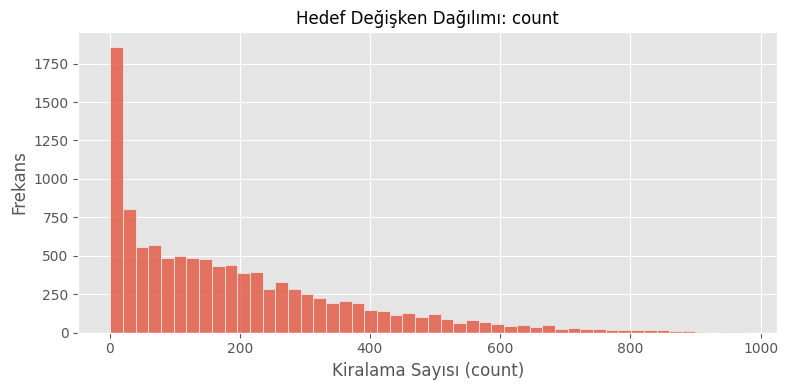

np.float64(1.2420662117180776)

In [11]:


fig, ax = plt.subplots(figsize=(8, 4))
sns.histplot(train["count"], bins=50, kde=False, ax=ax)
ax.set_title("Hedef Değişken Dağılımı: count", fontsize=12)
ax.set_xlabel("Kiralama Sayısı (count)")
ax.set_ylabel("Frekans")
plt.tight_layout()
plt.savefig(FIGURES / "target_count_distribution.png")
plt.show()

train["count"].skew()

- **Dağılım Yapısı:** Grafik net bir şekilde **sağa çarpık (right-skewed)** bir yapı gösteriyor. Hesaplanan Skewness değerinin pozitif çıkması da bunu istatistiksel olarak doğruluyor.
- **Talep Yoğunluğu:**
    - **0-50 arası:** En yüksek frekans burada. Çoğu saatte talep düşük.
    - **300+:** Yüksek kiralama sayıları oldukça seyrek (kuyruk kısmı).
- **Model Stratejisi (Kritik):** Hedef değişkenin bu çarpık yapısı ve yarışma metriğinin **RMSLE** olması sebebiyle; model eğitimine girmeden önce hedef değişkene **Logaritmik Dönüşüm (`np.log1p`)** uygulamak dağılımı normale yaklaştıracak ve model performansını artıracaktır. (Feature Engineering aşamasında uygulanacak).

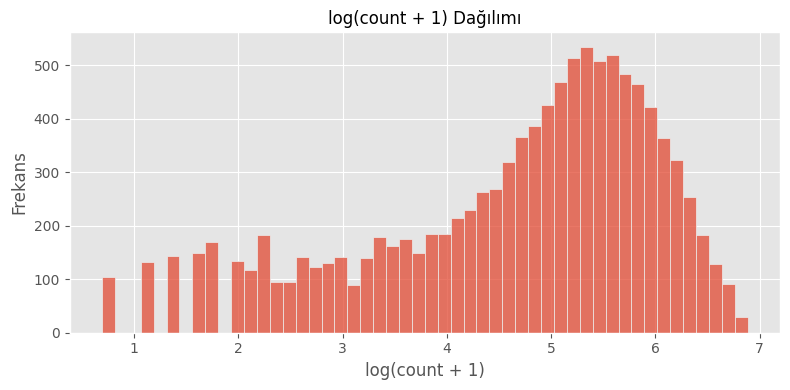

In [7]:
fig, ax = plt.subplots(figsize=(8, 4))
sns.histplot(np.log1p(train["count"]), bins=50, kde=False, ax=ax)
ax.set_title("log(count + 1) Dağılımı", fontsize=12)
ax.set_xlabel("log(count + 1)")
ax.set_ylabel("Frekans")
plt.tight_layout()
plt.savefig(FIGURES / "target_count_log_distribution.png")
plt.show()


**Logaritmik Dönüşüm Analizi:**
- **Neden:** Hedef değişkenin sağa çarpık yapısını düzeltmek ve RMSLE metriği ile uyumlu hale getirmek için `log1p` dönüşümü uyguladım.
- **Sonuç:**
    - Dağılım "Normal Dağılım"a (Gaussian) çok daha fazla yaklaştı.
    - Sağ ve sol kuyruklar dengelendi.
    - Yoğunluk 5-6 bandında (log scale) toplanmış durumda.
    - Bu yapı, modelin uç değerlerden (outliers) daha az etkilenmesini sağlayacaktır.

In [10]:
train["datetime"] = pd.to_datetime(train["datetime"])
test["datetime"] = pd.to_datetime(test["datetime"])

for df in [train, test]:
    df["year"] = df["datetime"].dt.year
    df["month"] = df["datetime"].dt.month
    df["day"] = df["datetime"].dt.day
    df["hour"] = df["datetime"].dt.hour
    df["dayofweek"] = df["datetime"].dt.dayofweek  
    df["is_weekend"] = df["dayofweek"].isin([5, 6]).astype(int)

train[["datetime", "year", "month", "day", "hour", "dayofweek", "is_weekend"]].head()


,datetime,year,month,day,hour,dayofweek,is_weekend
0,2011-01-01 00:00:00,2011,1,1,0,5,1
1,2011-01-01 01:00:00,2011,1,1,1,5,1
2,2011-01-01 02:00:00,2011,1,1,2,5,1
3,2011-01-01 03:00:00,2011,1,1,3,5,1
4,2011-01-01 04:00:00,2011,1,1,4,5,1


**Feature Extraction (Zaman Bazlı Özellikler):**
- **Yıl ve Mevsimsellik:** Veri 2011-2012 yıllarını kapsıyor. `head()` çıktısında sadece 2011'i görüyoruz ancak tüm veri setinde `year` değişkeni, yıllık büyüme trendini (growth) yakalamak için kritik olacak.
- **Yeni Featurelar:**
    - `hour`: Gün içindeki trafik saatlerini (sabah/akşam) yakalamak için en güçlü değişkenimiz.
    - `month`: Mevsimsellik etkisi için.
    - `is_weekend` & `dayofweek`: İş günü ve hafta sonu davranış farkını ayırmak için.
- **Kritik Not (Day Feature):** `day` değişkeni türetildi ancak bu veri setinde Train seti ayın ilk 19 gününü, Test seti ise 20'sinden sonrasını kapsıyor. Bu yapısal ayrım sebebiyle `day` değişkeni modelde kullanılırsa overfitting (aşırı öğrenme) yaratabilir veya anlamsız kalabilir. İleride feature selection aşamasında değerlendirilecek.

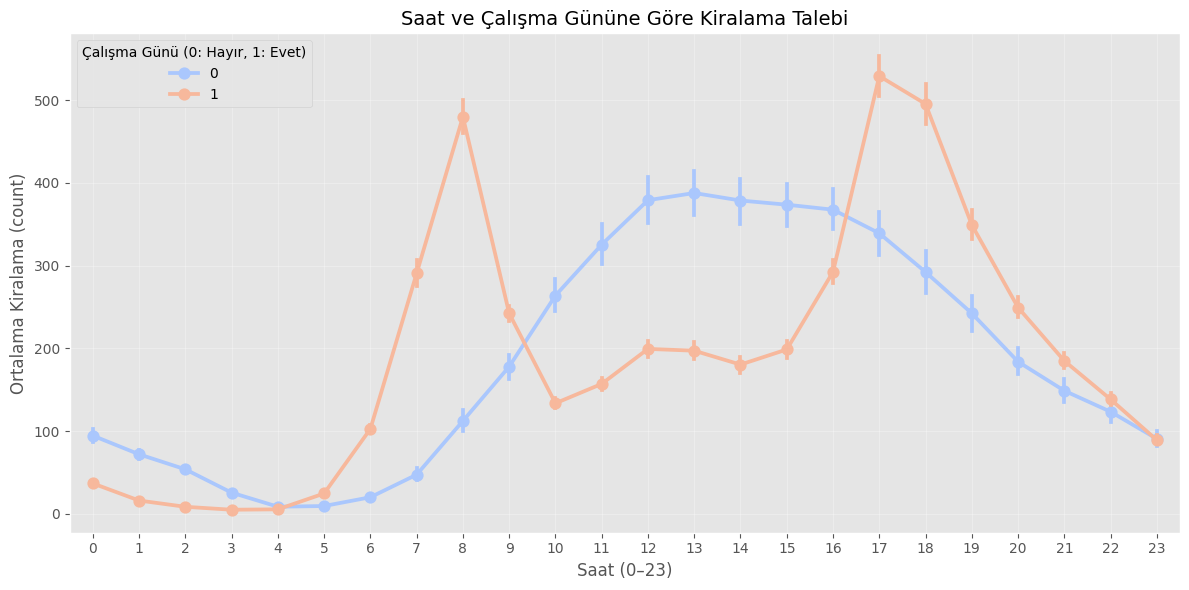

In [11]:
fig, ax = plt.subplots(figsize=(12, 6))

sns.pointplot(data=train, x="hour", y="count", hue="workingday", ax=ax, palette="coolwarm")

ax.set_title("Saat ve Çalışma Gününe Göre Kiralama Talebi", fontsize=14)
ax.set_xlabel("Saat (0–23)")
ax.set_ylabel("Ortalama Kiralama (count)")

ax.legend(title="Çalışma Günü (0: Hayır, 1: Evet)", loc="upper left")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(FIGURES / "count_by_hour_workingday.png")
plt.show()

**Saatlik Talep Analizi (Commuter vs. Leisure):**

- **Genel Yapı:** Saatlik talep incelendiğinde, kullanıcı davranışının "Çalışma Günü" ve "Tatil Günü" olarak iki tamamen farklı karaktere sahip olduğu görülüyor.
- **İş Günleri (Working Day = 1):**
    - **Çift Tepe (Bimodal) Yapı:** Sabah 08:00 ve Akşam 17:00-18:00 saatlerinde çok keskin iki zirve var.
    - **İçgörü:** Bu durum, kullanıcıların büyük çoğunluğunun **"Commuter" (Beyaz yakalı veya Öğrenci)** olduğunu ve bisikletleri ulaşım aracı olarak kullandığını kanıtlıyor.
    - **Ölü Saatler:** 10:00 - 15:00 arası talep düşüyor (herkes ofiste/okulda).
- **Hafta Sonu / Tatil (Working Day = 0):**
    - **Tek Tepe (Unimodal) Yapı:** Keskin sabah/akşam pikleri YOK.
    - **Çan Eğrisi:** Talep öğlen 12:00 - 16:00 arasında zirve yapıyor ve normal dağılıma benziyor.
    - **İçgörü:** Bu günlerde kullanım **"Leisure" (Gezi/Eğlence)** amaçlı. İnsanlar uyanıyor, öğlen gezmeye çıkıyor.
- **Model İçin Kritik Sinyal:** Model, saatin kaç olduğu bilgisini mutlaka `workingday` bilgisiyle kombine ederek (interaction) öğrenmeli. Çünkü saat 08:00'in anlamı hafta içi ve hafta sonu tamamen zıt.

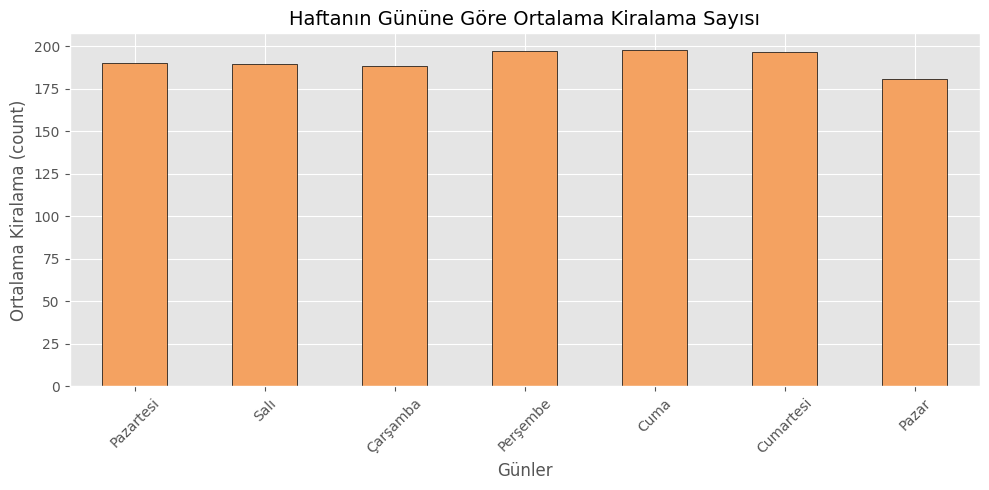

In [12]:
day_map = {0: 'Pazartesi', 1: 'Salı', 2: 'Çarşamba', 3: 'Perşembe', 4: 'Cuma', 5: 'Cumartesi', 6: 'Pazar'}

dow = train.groupby("dayofweek")["count"].mean()

fig, ax = plt.subplots(figsize=(10, 5))
dow.plot(kind="bar", ax=ax, color="#f4a261", edgecolor="black") 

ax.set_title("Haftanın Gününe Göre Ortalama Kiralama Sayısı", fontsize=14)
ax.set_xlabel("Günler")
ax.set_ylabel("Ortalama Kiralama (count)")

ax.set_xticklabels([day_map[i] for i in dow.index], rotation=45)

plt.tight_layout()
plt.savefig(FIGURES / "count_by_dayofweek.png")
plt.show()

**Günlük Talep Analizi:**
- **Dengeli Dağılım:** Günler arasındaki ortalama talep farkı beklediğimden az. Bu durum, `dayofweek` değişkeninin *tek başına* hedef değişken üzerindeki varyansı açıklamakta zorlanacağını gösteriyor.
- **Pazar Düşüşü:** Pazar günü (6) görülen belirgin düşüş, iş trafiğinin (commuter) olmaması ve insanların Pazar günlerini daha pasif geçirmesiyle açıklanabilir. Cumartesi günleri ise sosyal aktiviteler nedeniyle talep canlı kalıyor.
- **Stratejik İçgörü (Feature Interaction):** Veri bana şunu söylüyor: *"Beni tek başıma kullanma!"*
    - Pazartesi ve Pazar ortalaması yakın olabilir AMA Pazartesi sabah 08:00 ile Pazar sabah 08:00 tamamen farklıdır.
    - Bu yüzden modelde `dayofweek` değişkeni, `hour` değişkeniyle etkileşime girebilecek şekilde (örneğin Tree-based modellerle) kullanılmalıdır.

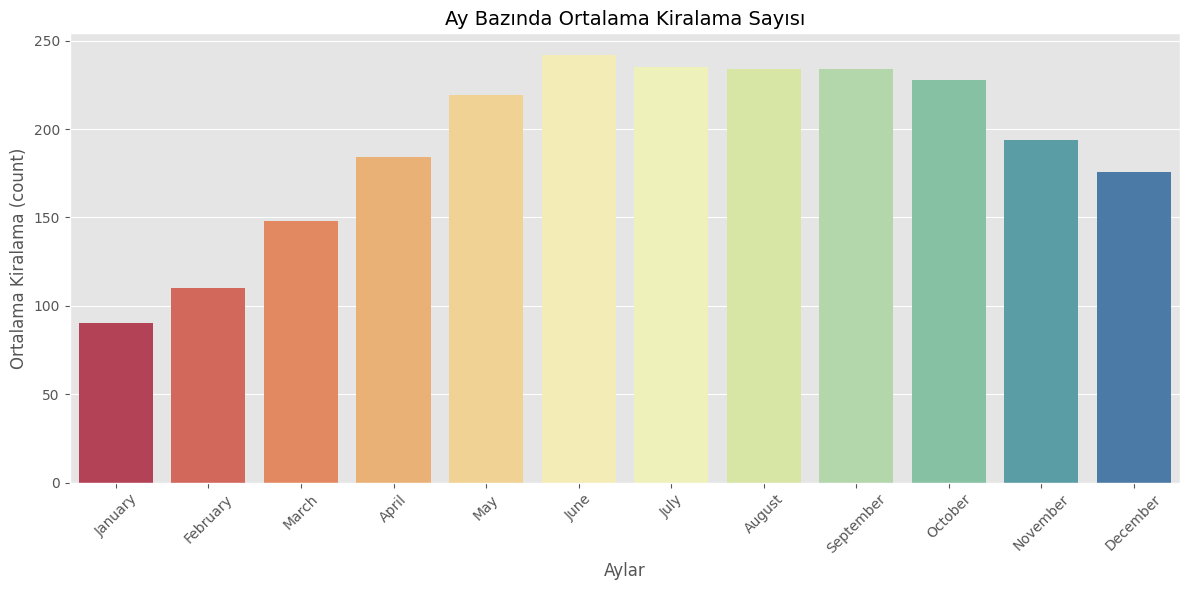

In [13]:
import calendar 

monthly = train.groupby("month")["count"].mean()

fig, ax = plt.subplots(figsize=(12, 6))
sns.barplot(x=monthly.index, y=monthly.values, ax=ax, palette="Spectral")

ax.set_title("Ay Bazında Ortalama Kiralama Sayısı", fontsize=14)
ax.set_xlabel("Aylar")
ax.set_ylabel("Ortalama Kiralama (count)")


ax.set_xticklabels([calendar.month_name[i] for i in monthly.index], rotation=45)

plt.tight_layout()
plt.savefig(FIGURES / "count_by_month.png")
plt.show()

**Mevsimsellik Analizi (Seasonality):**
- **Net Trend:** Grafik, bisiklet kullanımının mevsimsel etkilere çok açık olduğunu kanıtlıyor.
- **Pik Dönemi:** Haziran-Eylül arası (Yaz ve Erken Sonbahar) talep en üst seviyeye ulaşıyor (Ortalama 200+).
- **Düşüş Dönemi:** Ocak-Şubat gibi kış aylarında talep dip yapıyor (Ortalama 100 altı).
- **Feature Selection İpucu:** `month` değişkeni mevsimselliği `season` değişkeninden daha hassas (granular) açıkladığı için, modelde `season` yerine veya onunla birlikte kullanılması güçlü bir sinyal sağlayacaktır.

Ay vs Mevsim Dağılım Tablosu:

season    1    2    3    4
month                     
1       884    0    0    0
2       901    0    0    0
3       901    0    0    0
4         0  909    0    0
5         0  912    0    0
6         0  912    0    0
7         0    0  912    0
8         0    0  912    0
9         0    0  909    0
10        0    0    0  911
11        0    0    0  911
12        0    0    0  912
--------------------------------------------------


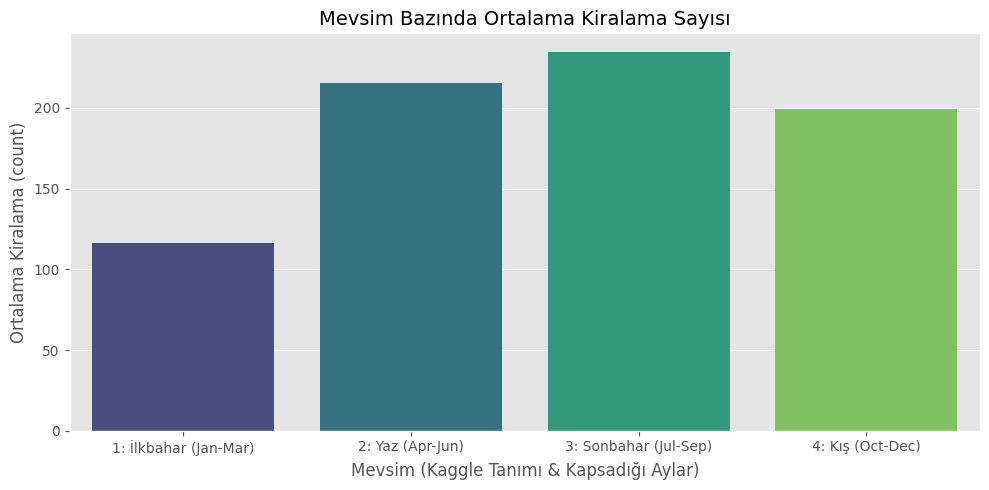

In [20]:
#Aylarda bir yanlışlık var, ilkbahar mevsimi ocak-şubat mart olarak görünüyor, mevsimler karışık... 
# Kaggle açıklamasına göre etiketler: 1:İlkbahar, 2:Yaz, 3:Sonbahar, 4:Kış

season_check = pd.crosstab(train['month'], train['season'])
print("Ay vs Mevsim Dağılım Tablosu:\n")
print(season_check)
print("-" * 50)


season_map = {1: '1: İlkbahar (Jan-Mar)', 
              2: '2: Yaz (Apr-Jun)', 
              3: '3: Sonbahar (Jul-Sep)', 
              4: '4: Kış (Oct-Dec)'}

seasonal = train.groupby("season")["count"].mean()

fig, ax = plt.subplots(figsize=(10, 5))
sns.barplot(x=[season_map[i] for i in seasonal.index], y=seasonal.values, ax=ax, palette="viridis")

ax.set_title("Mevsim Bazında Ortalama Kiralama Sayısı", fontsize=14)
ax.set_xlabel("Mevsim (Kaggle Tanımı & Kapsadığı Aylar)")
ax.set_ylabel("Ortalama Kiralama (count)")

plt.tight_layout()
plt.savefig(FIGURES / "count_by_season_check.png")
plt.show()

**Mevsimsel Analiz ve Veri Tutarlılığı (Data Consistency):**

- **Kritik Tespit (Mevsim-Ay Uyuşmazlığı):** - Kaggle veri seti açıklamasına göre `1=İlkbahar`, `2=Yaz` olarak belirtilmiştir.
  - Ancak `crosstab` analizi sonucunda, **Season 1** etiketinin **Ocak, Şubat ve Mart** aylarını kapsadığı görülmüştür.
  - Normalde Ocak ve Şubat kış ayıdır. Veri setindeki "İlkbahar" etiketi aslında **Yılın İlk Çeyreğini (Q1)** temsil etmektedir.
  
- **Grafik Yorumu:**
  - Grafikte "İlkbahar" (Season 1) talebinin en düşük çıkmasının sebebi, bu sezonun aslında en soğuk ayları (Ocak-Şubat) barındırmasından kaynaklanmaktadır.
  - En yüksek talep **Sonbahar (Season 3)** yani **Temmuz-Ağustos-Eylül** döneminde görülmektedir.
  
- **Aksiyon:** Model yorumlanırken bu etiket kayması (Season 1 = Soğuk Dönem) göz önünde bulundurulmalıdır.

Hatalı yaklaşım dokümante edildi, hafızadaki 'train' setiyle devam ediliyor.
----------------------------------------


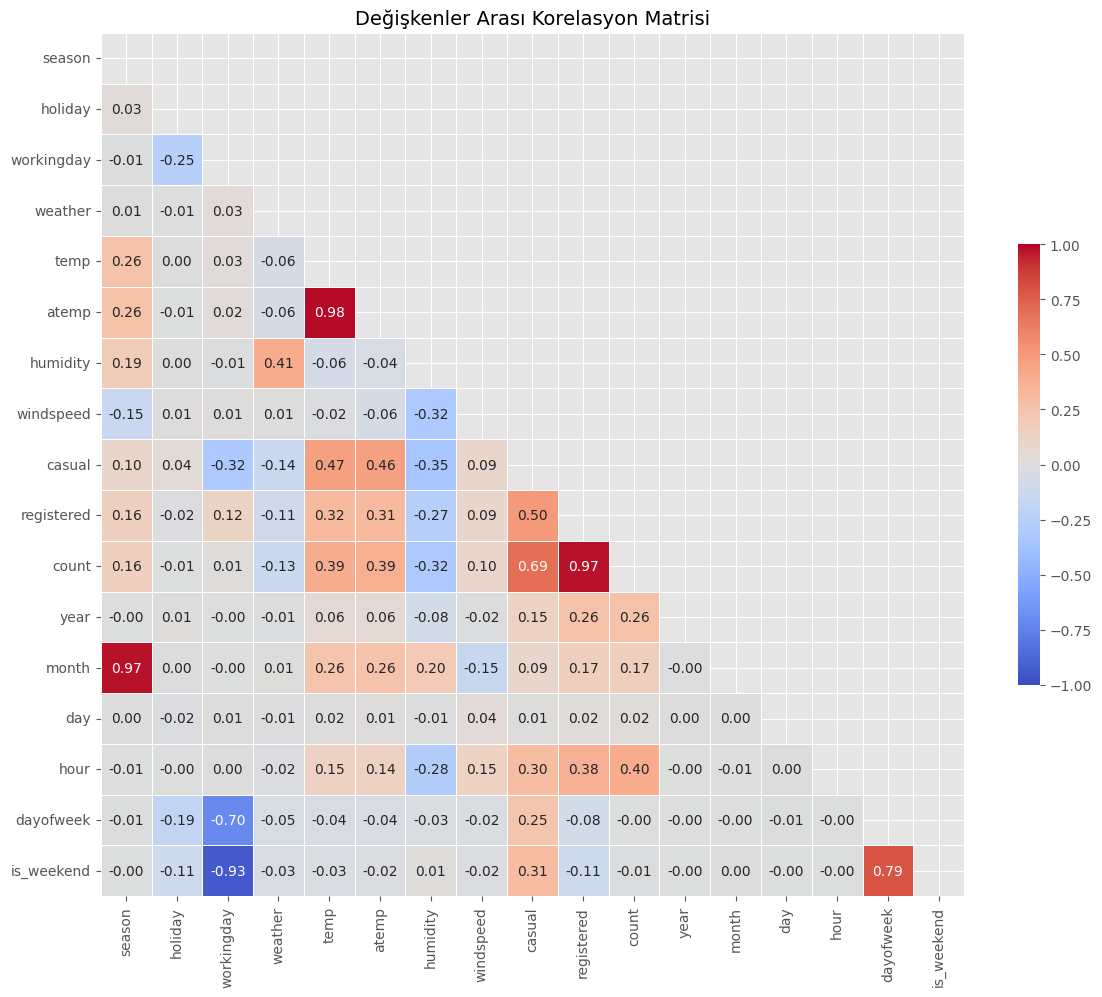

In [22]:
# 1. HATA KAYDI VE DÜZELTME 

# AŞAĞIDAKİ KOD BLOGU HATALIDIR
# Hata Sebebi: 'df = pd.read_csv(...)' diyerek veriyi tekrar ham haliyle okumak,
# yukarıda yaptığımız tüm temizlik (tarih formatı, outlier temizliği vb.) işlemlerini sıfırlar.
# Doğrusu: Hafızadaki işlenmiş 'train' değişkeni ile devam etmektir.

# if 'df' not in globals():
#    root = Path.cwd().parents[0]
#    df = pd.read_csv(root / "data" / "raw" / "train.csv") 
#    # ... (Gereksiz tekrar okuma)

print("Hatalı yaklaşım dokümante edildi, hafızadaki 'train' setiyle devam ediliyor.")
print("-" * 40)


numeric_cols = train.select_dtypes(include=[np.number]).columns.tolist()

corr_matrix = train[numeric_cols].corr()

mask = np.triu(np.ones_like(corr_matrix, dtype=bool)) 

fig, ax = plt.subplots(figsize=(12, 10))
sns.heatmap(corr_matrix, 
            mask=mask, 
            annot=True,     
            fmt=".2f",        
            cmap="coolwarm", 
            vmax=1, vmin=-1, 
            square=True, 
            linewidths=.5, 
            cbar_kws={"shrink": .5},
            ax=ax)

ax.set_title("Değişkenler Arası Korelasyon Matrisi", fontsize=14)
plt.tight_layout()
plt.savefig(FIGURES / "correlation_heatmap.png")
plt.show()

**Korelasyon Analizi ve Multicollinearity Kontrolü:**

- **Temp vs Atemp (Multicollinearity Uyarısı):**
    - `temp` (sıcaklık) ve `atemp` (hissedilen sıcaklık) arasında **0.98** gibi mükemmele yakın bir korelasyon var.
    - **Aksiyon:** Bu iki değişken aynı bilgiyi taşıyor. İkisini aynı anda modele sokmak, modelin ağırlıklarını (weights) dengesizleştirebilir. Feature Engineering aşamasında bunlardan sadece biri tutulmalı veya PCA uygulanmalıdır.

- **Humidity (Nem):**
    - Hedef değişken (`count`) ile negatif korelasyona sahip. Nem arttıkça (yağmurlu/basık hava) bisiklet kullanımı azalıyor. Mantıklı.

- **Hedef Değişken (Count) İlişkileri:**
    - En yüksek pozitif etki `hour` (saat), `temp` (sıcaklık) ve `year` değişkenlerinden geliyor.
    - `casual` ve `registered` değişkenleri hedefle %69 ve %97 oranında ilişkili (doğal olarak), ancak bunlar test setinde olmadığı için modelde girdi olarak kullanılmayacak.

- **Teknik Not (Hata Yönetimi):**
    - Önceki adımda veriyi tekrar okuma (re-reading) hatası fark edildi. Veri işleme akışının (pipeline) bozulmaması için hafızadaki işlenmiş `train` seti korunarak analize devam edildi.

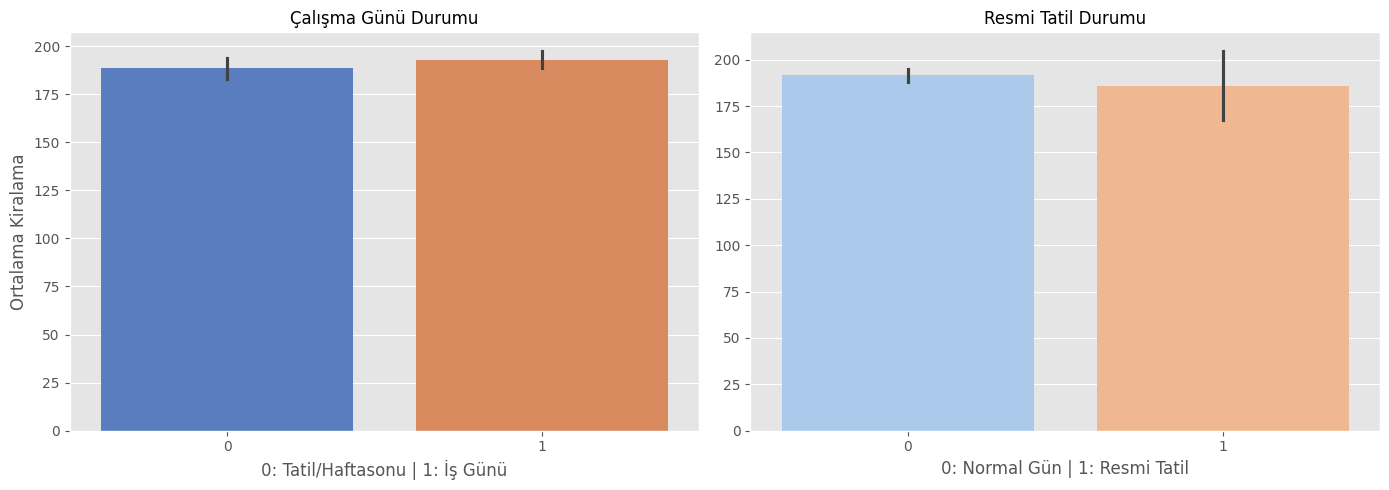

In [23]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# 1. Working Day (İş Günü)
# 0: Haftasonu/Tatil, 1: İş Günü
sns.barplot(data=train, x='workingday', y='count', ax=axes[0], palette="muted")
axes[0].set_title("Çalışma Günü Durumu", fontsize=12)
axes[0].set_xlabel("0: Tatil/Haftasonu | 1: İş Günü")
axes[0].set_ylabel("Ortalama Kiralama")

# 2. Holiday (Resmi Tatil)
# 0: Normal Gün, 1: Resmi Tatil
sns.barplot(data=train, x='holiday', y='count', ax=axes[1], palette="pastel")
axes[1].set_title("Resmi Tatil Durumu", fontsize=12)
axes[1].set_xlabel("0: Normal Gün | 1: Resmi Tatil")
axes[1].set_ylabel("") 

plt.tight_layout()
plt.savefig(FIGURES / "workingday_holiday_comparison.png")
plt.show()

**İş Günü ve Tatil Analizi (Ortalama Tuzağı):**

- **Gözlem:** `workingday` ve `holiday` değişkenlerine sadece ortalama bazında bakıldığında, kategoriler arasında belirgin bir fark görülmemektedir (Ortalamalar 180-190 bandında).
- **Yanılgı (Aggregation Bias):** Bu durum, "Bu değişkenler önemsizdir" yanılgısı yaratabilir.
- **Gerçek:** Önceki saatlik analizlerimizde (`hour` vs `count`) gördük ki; bu günlerin **toplam talebi** benzer olsa da **saatlik dağılımı** (sabah/akşam piki vs öğlen piki) tamamen zıttır.
- **Sonuç:** Bu değişkenler modelde "tek başına" (main effect) çok ayırıcı olmayabilir, ancak "saat" değişkeni ile birlikte (interaction effect) modelin en kritik özelliklerini oluşturacaktır.

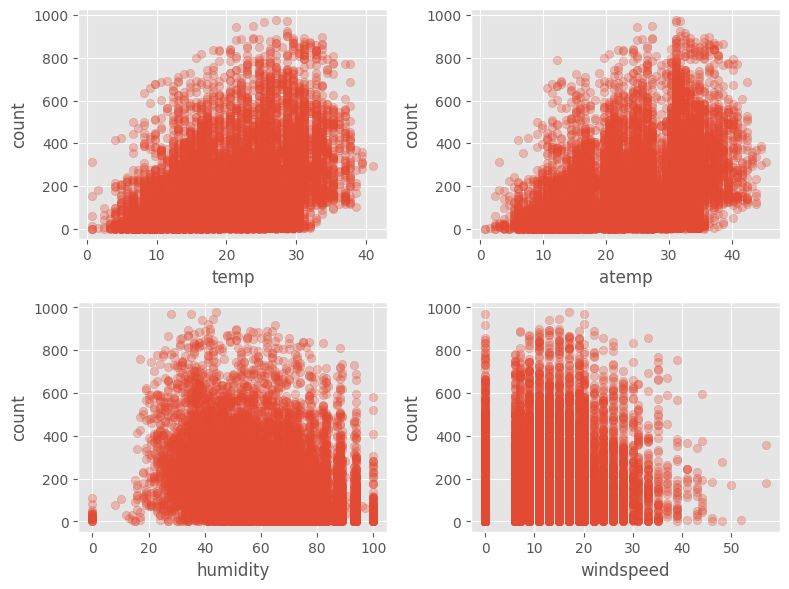

In [12]:
if 'train' not in globals():
    train = pd.read_csv(train_path)

train['datetime'] = pd.to_datetime(train['datetime'])

cols = ["temp", "atemp", "humidity", "windspeed"]

fig, axes = plt.subplots(2, 2, figsize=(8, 6))
axes = axes.flatten()

for ax, col in zip(axes, cols):
    ax.scatter(train[col], train["count"], alpha=0.3)
    ax.set_xlabel(col)
    ax.set_ylabel("count")

fig.tight_layout()
fig.savefig(FIGURES / "count_vs_weather_numeric.png", dpi=120)
plt.show()



**Sayısal Değişken Analizi (Continuous Features):**

- **Temp & Atemp (Doğrusallık Dışı İlişki):**
    - Sıcaklık ve talep arasındaki ilişki tam olarak doğrusal (linear) değil.
    - Düşük sıcaklıklarda talep az, sıcaklık arttıkça artıyor ANCAK çok yüksek sıcaklıklarda (35+ derece) tekrar düşüş eğilimi var.
    - **Model İpucu:** Bu "tepe yapan" yapı, Lineer Modellerin tek başına zorlanacağı bir durumdur. Polynomial features eklenmeli veya Tree-based (Ağaç tabanlı) modeller tercih edilmelidir.

- **Humidity (Nem):**
    - Negatif bir korelasyon var. Nem %100'e yaklaştığında (yağmur ihtimali) talep neredeyse sıfırlanıyor.

- **Windspeed (Veri Kalitesi Uyarısı):**
    - Grafikte `windspeed=0` değerinde doğal olmayan bir yığılma (dikey çizgi) görülüyor.
    - Bu durum, rüzgar hızı ölçülemeyen anların **0 ile doldurulduğunu (bad imputation)** işaret ediyor.
    - **Aksiyon:** Feature Engineering aşamasında bu 0 değerleri, "Ortalama" veya "Machine Learning tabanlı bir tahmin" ile düzeltilirse model başarısı artabilir.

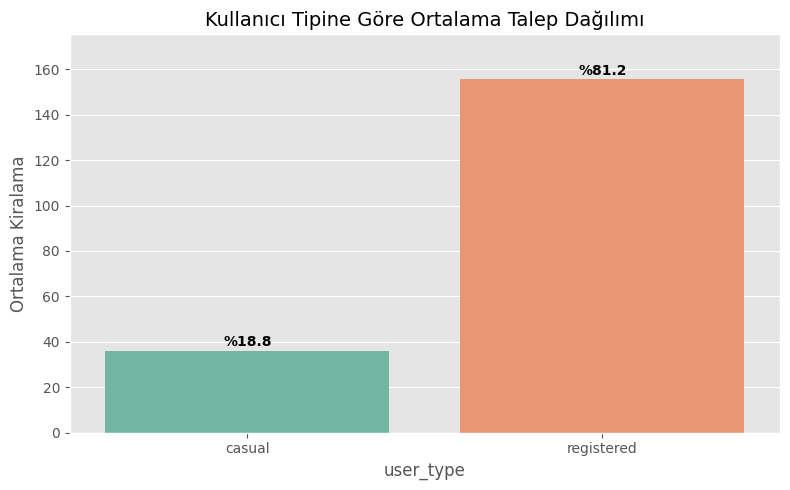

In [26]:
if 'train' not in globals():
    train = pd.read_csv(train_path)

user_means = train[["casual", "registered"]].mean().reset_index()
user_means.columns = ["user_type", "average_count"]

total_mean = user_means["average_count"].sum()
user_means["percentage"] = (user_means["average_count"] / total_mean) * 100

fig, ax = plt.subplots(figsize=(8, 5))

sns.barplot(data=user_means, x="user_type", y="average_count", ax=ax, palette="Set2")

for index, row in user_means.iterrows():

    ax.text(index, row['average_count'] + 2, 
            f"%{row['percentage']:.1f}", 
            color='black', ha="center", weight='bold')

ax.set_title("Kullanıcı Tipine Göre Ortalama Talep Dağılımı", fontsize=14)
ax.set_ylabel("Ortalama Kiralama")
ax.set_ylim(0, user_means['average_count'].max() + 20) 

plt.tight_layout()
plt.savefig(FIGURES / "avg_casual_vs_registered.png")
plt.show()

**Kullanıcı Profili Analizi:**

- **Gözlem:** Kayıtlı kullanıcıların talebi, casual kullanıcılara kıyasla belirgin biçimde daha yüksektir (%81 vs %19). Toplam talep, ağırlıklı olarak bu kullanıcı grubu tarafından taşınmaktadır.
- **Data Leakage Uyarısı:** Bu iki değişken (`casual` ve `registered`), hedef değişkeni (`count`) doğrudan oluşturan bileşenler olduğu için (`count = casual + registered`) **modelleme aşamasına (input olarak) kesinlikle dahil edilmemelidir.**
- **Amaç:** Bu analiz yalnızca talebin kullanıcı profiline göre nasıl dağıldığını görmek ve iş modelini anlamak amacıyla yapılmıştır.

#  EDA Sonuçları ve Karar Matrisi

Yapılan analizler sonucunda elde edilen bulgular ve bir sonraki aşama (Feature Engineering & Modeling) için alınan aksiyon kararları aşağıdadır.

###  Feature Karar Tablosu

| Değişken(ler) | Durum | Karar / Aksiyon |
| :--- | :---: | :--- |
| **hour, month, year** |  **KEEP** | Modelin en güçlü belirleyicileri. `hour`, gün içi trafiği; `month` ve `year` mevsimsellik ve trendi açıklar. |
| **temp, atemp, humidity** |  **KEEP** | Hava durumu talep üzerinde doğrudan etkilidir. `temp` ve `atemp` yüksek korelasyonlu olduğu için PCA veya seçim yapılabilir. |
| **windspeed** |  **FIX** | `0` değerleri (hatalı veri) içeriyor. Baseline sonrası doldurulması (imputation) gerekir. |
| **weather** |  **GROUP** | `Weather=4` (Fırtına) çok az veriye sahip olduğu için `Weather=3` ile birleştirilmeli. |
| **season** |  **NOTE** | Veri setinde "Sezon 1", en soğuk ayları (Ocak-Mart) kapsıyor. Etiket yanıltıcı olabilir, `month` daha güvenilir. |
| **workingday, holiday** |  **INTERACT** | Tek başına zayıf sinyaller. Ancak `hour` ile birleşince (Hafta içi sabah trafiği vs Hafta sonu öğlen trafiği) kritik önem taşır. |
| **day, dayofweek** |  **WEAK** | `day` (gün) train/test ayrımından dolayı modelde kullanılamaz. `dayofweek` ise hafta sonu ayrımı dışında zayıf kalıyor. |
| **casual, registered** |  **DROP** | **Data Leakage!** Hedef değişkenin parçalarıdır. Eğitimde asla kullanılmayacak. |
| **COUNT (Target)** |  **TRANSFORM** | Sağa çarpık dağılım. RMSLE metriği için **Logaritmik Dönüşüm (`log1p`)** şart. |

---
**Sıradaki Adım:** `02_baseline.ipynb` ile en basit modelin kurulması ve referans skorun belirlenmesi.